In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [47]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.001,
               'scale': .1,
               'delta': 1.11,
               'rho': .4,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -0.01,
                   'pi': -0.36,
                   'theta': 0.53}
    
time_dim = 500
sim_dim = 100
innov_dim = 20

In [48]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [49]:
vl.compute_gamma(**true_params)

0.013242276934370757

In [50]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.36,
 'theta': 0.53,
 'gamma': 0.013242276934370757,
 'beta': 0.04780447809346999,
 'psi': -0.03421183442037379,
 'zeta': 0.9999}

In [51]:
true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.36,
 'theta': 0.53}

In [52]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.36,
 'theta': 0.53,
 'gamma': 0.013242276934370757,
 'beta': 0.04780447809346999,
 'psi': -0.03421183442037379,
 'zeta': 0.9999}

## We start by examining the distributions of simulated data

In [53]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [54]:
omega, omega_cov = vl.estimate_params(data)

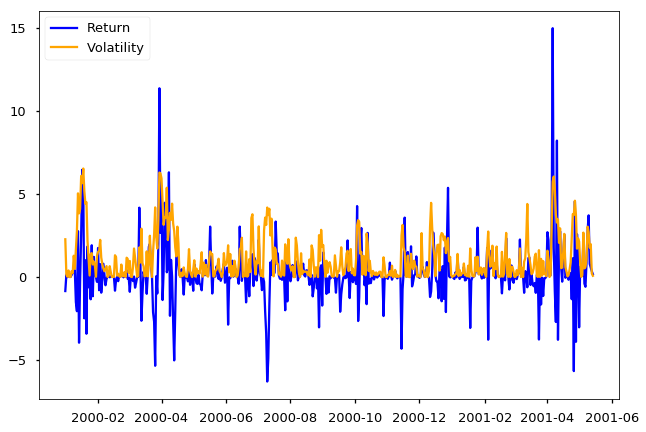

In [55]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [56]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,1.736743,0.394851
rtn,0.394851,2.843483


In [57]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.36,
 'theta': 0.53,
 'gamma': 0.013242276934370757,
 'beta': 0.04780447809346999,
 'psi': -0.03421183442037379,
 'zeta': 0.9999}

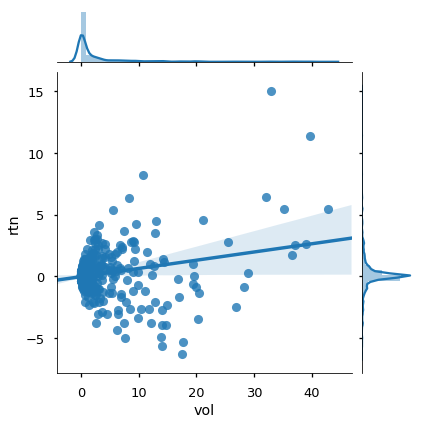

In [58]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [59]:
true_params['delta']

0.27

In [60]:
true_params['scale']

3.11

In [61]:
data.describe()

,vol,rtn
count,500.000000,500.000000
mean,2.998401,0.181793
std,6.329226,1.686263
min,0.000010,-6.286204
25%,0.015114,-0.190203
50%,0.422725,0.049600
75%,2.695689,0.446486
max,42.733047,14.986224


## I now estimate all of the parameters

In [62]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [63]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [23]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [24]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

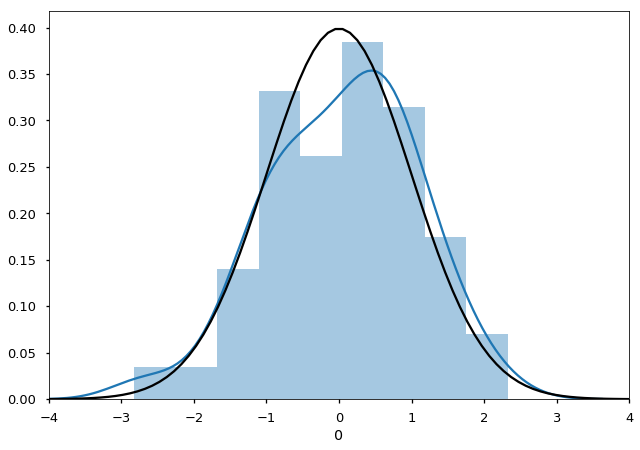

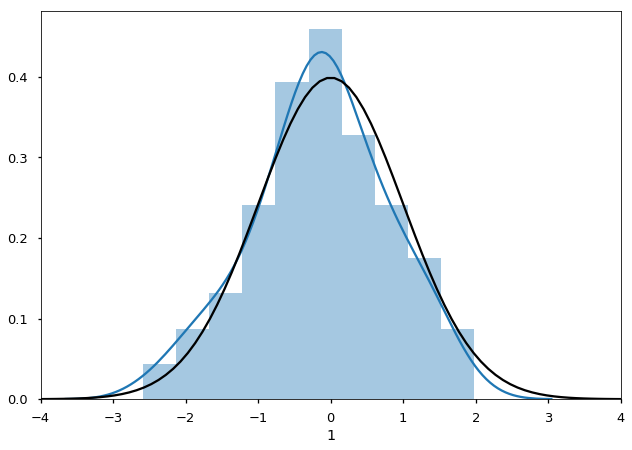

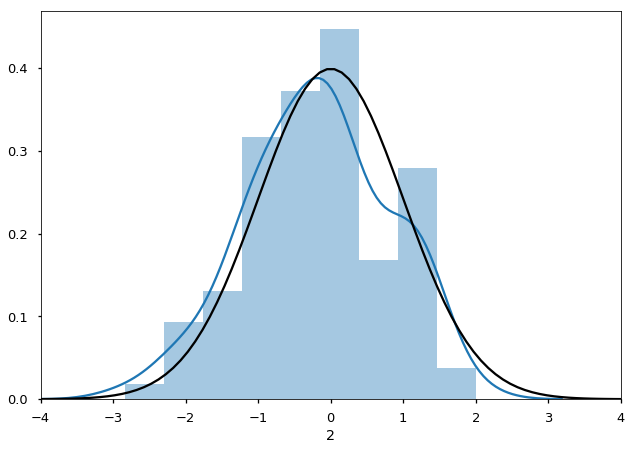

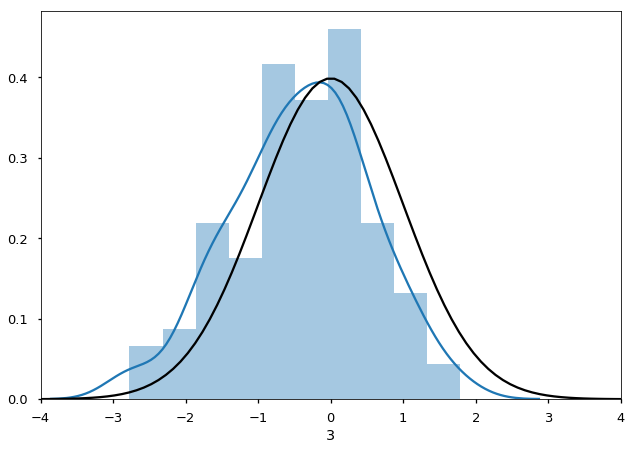

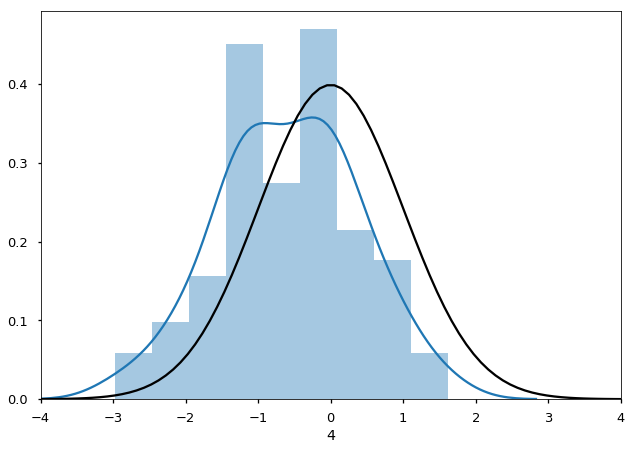

In [25]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

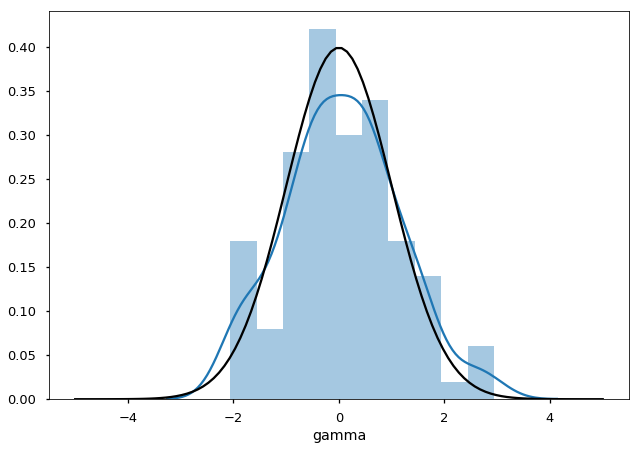

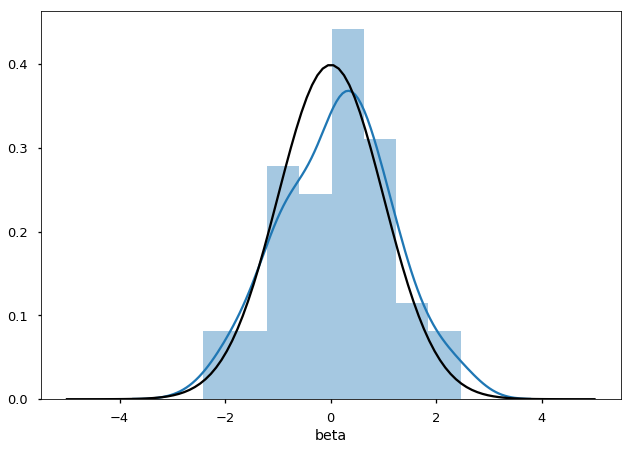

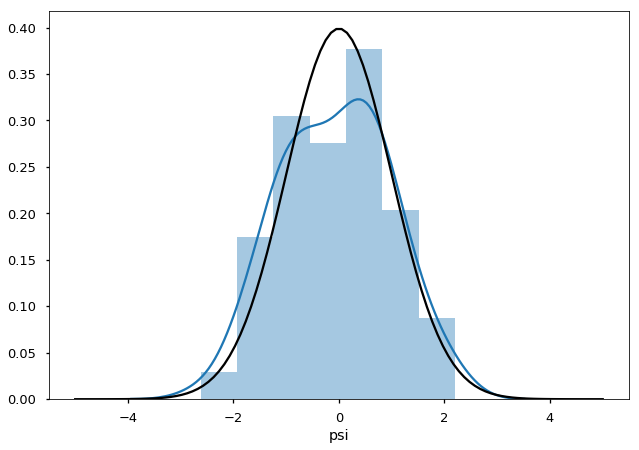

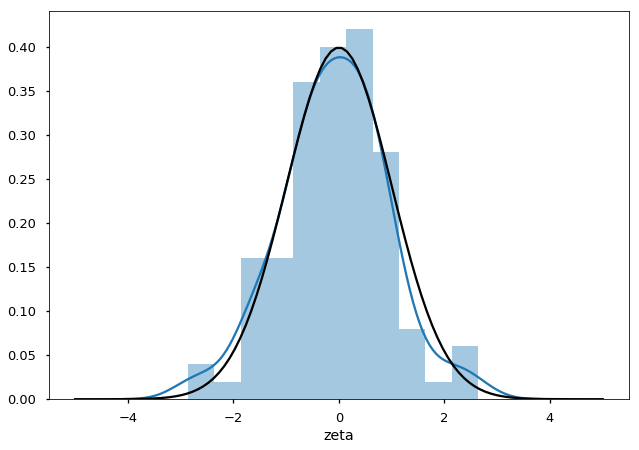

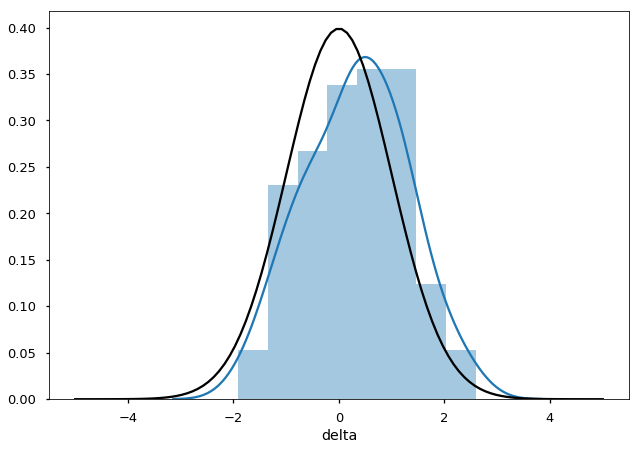

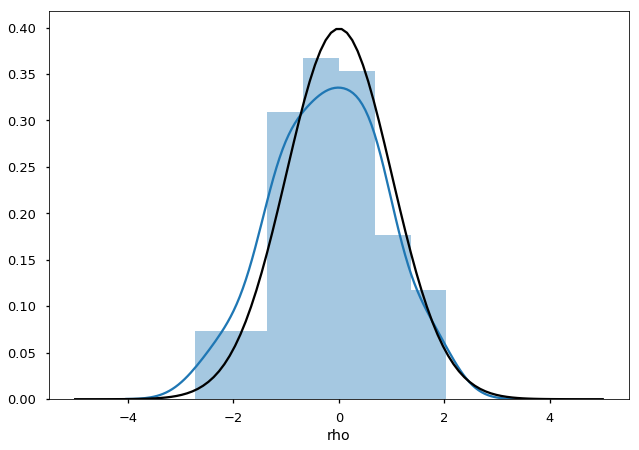

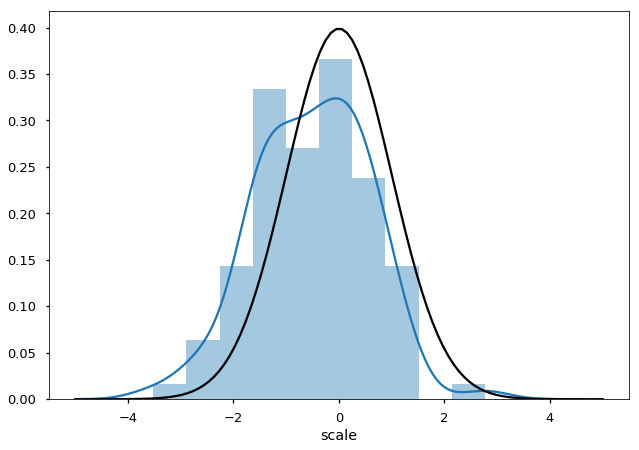

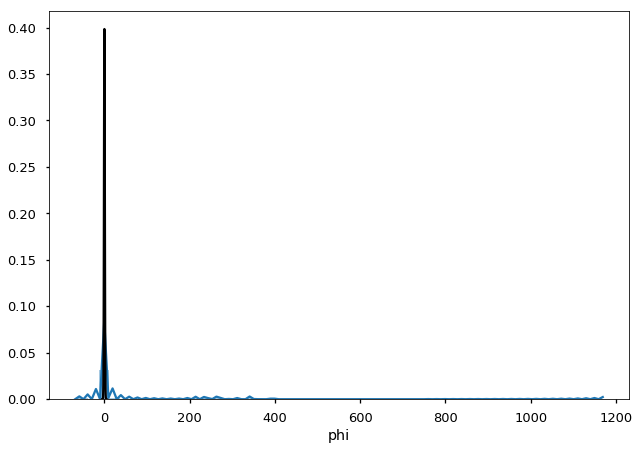

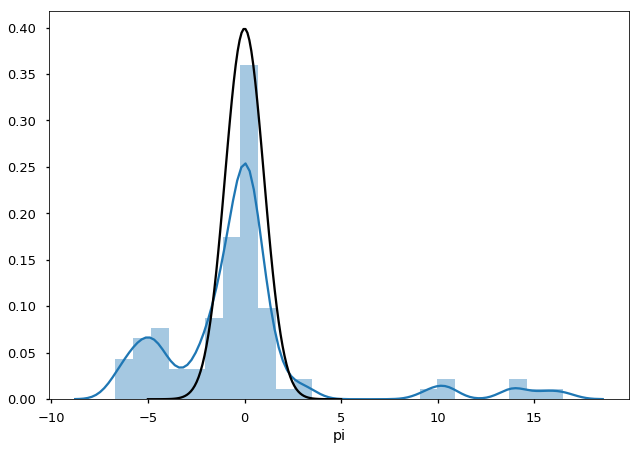

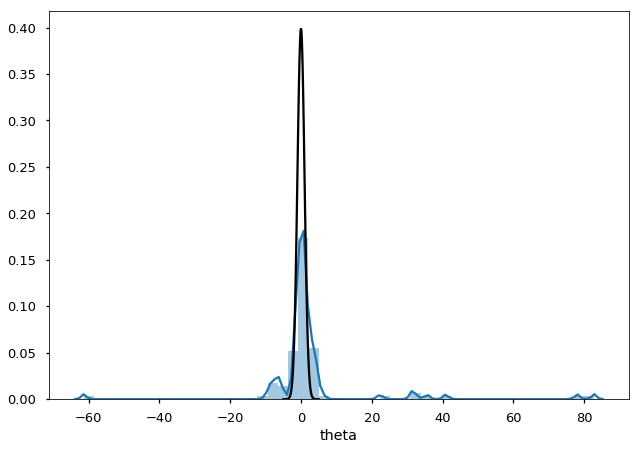

In [26]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)

# I now compute the robust conditional QLR statistic 

In [27]:
omega


{'gamma': 0.012579393304927237,
 'beta': 0.04798893212952292,
 'psi': -0.03325649292445177,
 'zeta': 1.0048289079050148,
 'delta': 0.29421821119766517,
 'rho': 0.7922455847440342,
 'scale': 2.9537803876691533}

In [28]:
true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.36,
 'theta': 0.53}

In [31]:
def compute_vals(idx):
    omega = pd.Series(est_arr[idx][0]).drop(['phi', 'pi', 'theta']).to_dict()
    omega_cov = est_arr[idx][1].drop(columns=['phi', 'pi', 'theta']).drop(index=['phi', 'pi', 'theta'])
    sims = vl.qlr_sim([true_params['phi'], true_params['pi'], true_params['theta']], omega=omega, 
                      omega_cov=omega_cov, innov_dim=10, case=1)
    val = vl.qlr_stat([true_params['phi'], true_params['pi'], true_params['theta']], omega=omega,
                       omega_cov=omega_cov, case=1)[-1]
    
    return (val,) + tuple(sims)

In [32]:
total=min(100, len(est_arr))
with Pool(8) as pool:
    results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, range(total)),
                                                          total=total))))

In [33]:
results.head()

,0,1,2,3,4,5,6,7,8,9,10
0,2.057684,1.020767,0.558703,1.306133,1.906038,2.207993,1.364388,5.227920,1.988530,1.350977,3.223530
1,3.518098,1.020370,0.558374,1.305106,1.905822,2.207025,1.364471,5.227640,1.989689,1.351861,3.224161
2,3.466219,1.020780,0.558678,1.305992,1.905900,2.208054,1.364355,5.228750,1.988708,1.350592,3.223424
3,1.839781,1.020514,0.558250,1.305456,1.905437,2.207428,1.364300,5.229219,1.990036,1.350927,3.223799
4,15.291556,1.020313,0.557962,1.304229,1.904340,2.207199,1.364262,5.231994,1.992160,1.349561,3.223597


In [34]:
import cdpm

In [35]:
robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
                                    reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [36]:
standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [37]:
standard_pit

array([0.439, 0.682, 0.675, 0.394, 0.998, 0.004, 0.872, 0.997, 0.655,
       0.829, 0.866, 0.855, 0.169, 0.056, 0.142, 0.482, 0.755, 0.071,
       0.333, 0.422, 0.862, 0.679, 0.999, 0.245, 0.515, 0.094, 0.99 ,
       0.39 , 0.163, 0.89 , 0.39 , 1.   , 0.952, 0.803, 0.418, 0.983,
       0.815, 0.289, 0.286, 0.927, 0.905, 0.495, 0.849, 0.786, 0.198,
       0.539, 0.534, 0.581, 0.771, 0.601, 0.562, 0.267, 0.652, 0.868,
       0.25 , 0.82 , 0.695, 0.056, 0.703, 1.   , 0.26 , 0.934, 1.   ,
       0.174, 0.021, 0.564, 0.854, 0.735, 0.807, 0.931, 0.725, 0.793,
       0.25 , 1.   , 0.608, 0.338, 0.82 , 0.382, 0.828, 0.954, 0.634,
       0.892, 0.026, 0.922, 0.292, 0.928, 0.947, 0.604, 0.359, 0.763,
       0.563, 0.207, 0.845, 0.397, 0.339, 0.207, 0.381, 0.497, 0.73 ,
       0.785])

In [38]:
true_prices = true_params['phi'], true_params['pi'], true_params['theta']

In [39]:
true_prices

(-0.01, -0.36, 0.53)

In [40]:
def g_true_thing(true_prices, est):
    
    param_est, param_cov = est
    names = ['theta', 'phi', 'pi']
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T

    cov_true_true = vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
    link_true = vl.compute_link(true_prices, omega, case=1)

    return np.linalg.solve(np.linalg.cholesky(cov_true_true), link_true)

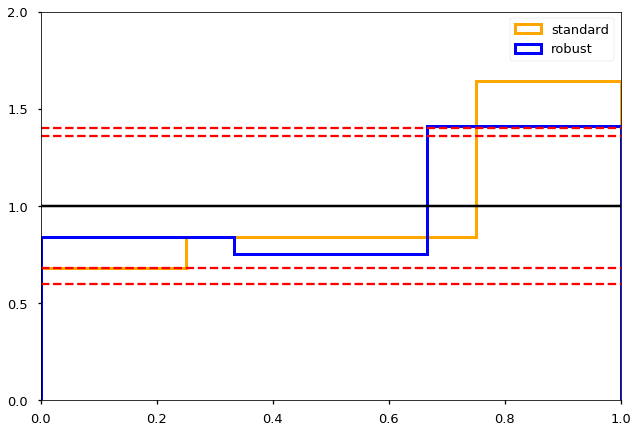

In [41]:
fig, ax = mpl.pyplot.subplots()
cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='standard')
cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='robust')
ax.legend()
fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [42]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=500, alpha=0.05, case=0,
                                        robust_quantile=True)

In [43]:
returnval.mean()

qlr_stat               0.592126
robust_qlr_qauntile    2.864709
robust                 0.050000
standard               0.030000
dtype: float64

In [44]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
else:
    filename = '../results/reject_prop_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
    
returnval.to_json(filename)

In [45]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,0.103538,3.051276,False,False
1,0.003165,3.051276,False,False
2,0.003983,3.051276,False,False
3,0.016395,3.051276,False,False
4,0.002085,3.051276,False,False


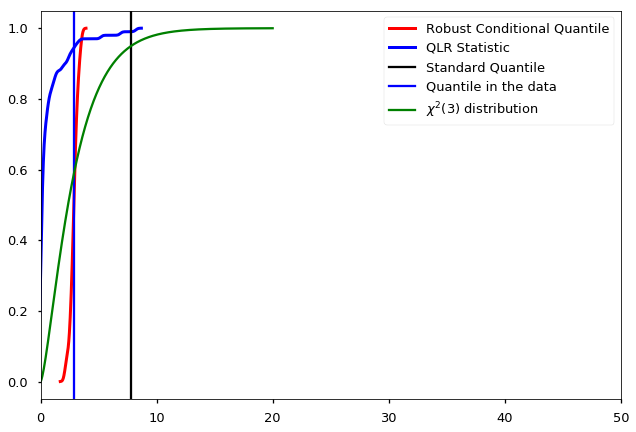

In [46]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.robust_qlr_qauntile, kde_kws={"color": "red", "lw": 3, 'cumulative':True},
                 ax=ax4,hist=False, label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)